In [1]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
nifty5 = pd.read_csv('Cleaned_Nifty50_5min.csv')
nifty5['EMA']=nifty5['Close'].ewm(span=5, adjust=False).mean()

In [3]:
nifty5

,Date,Open,High,Low,Close,Time,EMA
0,09-01-2015,8285.45,8301.30,8285.45,8301.20,09:15,8301.200000
1,09-01-2015,8300.50,8303.00,8293.25,8301.00,09:20,8301.133333
2,09-01-2015,8301.65,8302.55,8286.80,8294.15,09:25,8298.805556
3,09-01-2015,8294.10,8295.75,8280.65,8288.50,09:30,8295.370370
4,09-01-2015,8289.10,8290.45,8278.00,8283.45,09:35,8291.396914
...,...,...,...,...,...,...,...
114220,25-03-2021,14338.40,14349.70,14319.05,14319.05,15:05,14373.149535
114221,25-03-2021,14319.15,14320.25,14274.15,14299.00,15:10,14348.433023
114222,25-03-2021,14298.90,14315.80,14287.55,14299.75,15:15,14332.205349
114223,25-03-2021,14299.45,14317.40,14295.75,14314.95,15:20,14326.453566


In [12]:
daysconsidered=1500 #offset to start for some given date
a=nifty5.Date.nunique()-daysconsidered

c1 = pd.DataFrame(columns=['Date', 'Number of trades','Average time','Balance'])
c1['Date'] = nifty5['Date']
c1['Number of trades']=0
c1['Average time']=0
c1['Balance']=0

c2 = pd.DataFrame(columns=['Date', 'Time','Balance'])
c2['Date'] = nifty5['Date']
c2['Time'] = nifty5['Time']
c2['Balance'] = nifty5['Open']

profp=[]
lossp=[]
th=[]

def buy(i,j,tgt,sl):
    global profp,lossp,th
    byp=nifty5['Close'][i*75+j]
    d=nifty5['Date'][i*75+j]
    for k in range(j,70):
        if nifty5['Close'][i*75+k]<sl:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(byp-sl)/byp)
            return sl
        if nifty5['High'][(i)*75+k]>tgt:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Target hit!'.format(d,tgt,sl))
            profp.append(100*(tgt-byp)/byp)
            return tgt
    #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    return nifty5['Low'][i*75+k]

def sell(i,j,tgt,sl):
    global profp,lossp,th
    slp=nifty5['Close'][i*75+j]
    d=nifty5['Date'][i*75+j]
    k=j
    for k in range(j,70):
        if nifty5['Close'][i*75+k]>sl:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(sl-slp)/slp)
            th.append(k-j)
            return k, sl
        if nifty5['Low'][i*75+k]<tgt:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Target hit!'.format(d,tgt,sl))
            profp.append(100*(slp-tgt)/slp)
            th.append(k-j)
            return k, tgt
    #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    th.append(k-j)
    return k, nifty5['Close'][i*75+k]

proftolossratio=1.5
ini=nifty5['Open'][a*75]
balance=ini
minbalance=ini
maxbalance=0
tgt1=0
sl1=0
profit=0
leverage=1
for i in range(a,nifty5.Date.nunique()):
    profit=0
    #n=math.ceil(1,int(balance/nifty5['Open'][i*75]))
    k1=0
    if i>=1:
        c2.at[i*75, 'Balance'] = c2.loc[i*75-1, 'Balance']
    for j in range(1,nifty5.Time.nunique()):
        c2.at[i*75+j, 'Balance'] = c2.loc[i*75+j-1, 'Balance']
        if j<=k1:
            continue
        if nifty5['Close'][i*75+j-1]>nifty5['EMA'][i*75+j-1]:
            if nifty5['Close'][i*75+j]<nifty5['Open'][i*75+j]:
                if nifty5['Close'][i*75+j]<nifty5['EMA'][i*75+j]:
                    stpls=nifty5['High'][i*75+j-1]-nifty5['Close'][i*75+j]
                    trgt=nifty5['Close'][i*75+j]-stpls*proftolossratio
                    k1, byp=sell(i,j,trgt,nifty5['High'][i*75+j-1])       
                    profit=profit+nifty5['Close'][i*75+j]-byp
                    c1.at[i*75, 'Number of trades']+=1
                    c2.at[i*75+j, 'Balance'] = c2.loc[i*75+j, 'Balance'] + nifty5['Close'][i*75+j]-byp                 
    
    th=np.array(th)
    c1.at[i*75, 'Average time'] = th.mean()*5
    th=[]
    balance=balance+leverage*profit
    c1.at[i*75, 'Balance'] = balance
    if balance<0:
        print("Total Loss")
        break
    if balance>=maxbalance:
        maxbalance=balance
    if balance<minbalance:
        minbalance=balance
        
balance=c2['Balance'].values[-1]
res=(balance-ini)/ini
print('Total count of trade days :',len(c1[c1['Number of trades']!=0]),'out of ',nifty5.Date.nunique()-a,' days')
print('Average number of trades per day: {:.2f}'.format(c1[c1['Number of trades']!=0]['Number of trades'].mean()))
print('Average time held per trade: {:.2f} minutes \n'.format(c1[c1['Number of trades']!=0]['Average time'].mean()))
if balance>=ini:
    print("Final Balance is ₹{:.2f} with return of {:.2f}%".format(balance,res*100))
else:
    print("Final Balance is ₹{:.2f} with a loss of {:.2f} at {:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))
print("Nifty Return for the same time period is {:.2f}%".format(100*(nifty5['Close'][(i)*75+j]-nifty5['Close'][a*75+j])/nifty5['Close'][a*75+j]))
profp=np.array(profp)
lossp=np.array(lossp)
pn=len(profp)
ln=len(lossp)
pm=profp.mean()
lm=lossp.mean()
print('\nNumber of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))
print('\nRESULTS WITH LEVERAGE OF 5x')
profp=profp*leverage
lossp=lossp*leverage
pm=profp.mean()
lm=lossp.mean()
print('Number of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))

Total count of trade days : 1500 out of  1500  days
Average number of trades per day: 5.38
Average time held per trade: 46.76 minutes 

Final Balance is ₹24010.80 with return of 171.88%
Minimum Balance was ₹8801.43 and Maximum Balance was ₹24047.65
Nifty Return for the same time period is 62.87%

Number of Profits: 3187 Losses: 3341 
Average Profit: 0.17% Average Loss: 0.12%
Win ratio of: 48.82% and net profit per trade of 0.02%

RESULTS WITH LEVERAGE OF 5x
Number of Profits: 3187 Losses: 3341 
Average Profit: 0.17% Average Loss: 0.12%
Win ratio of: 48.82% and net profit per trade of 0.02%


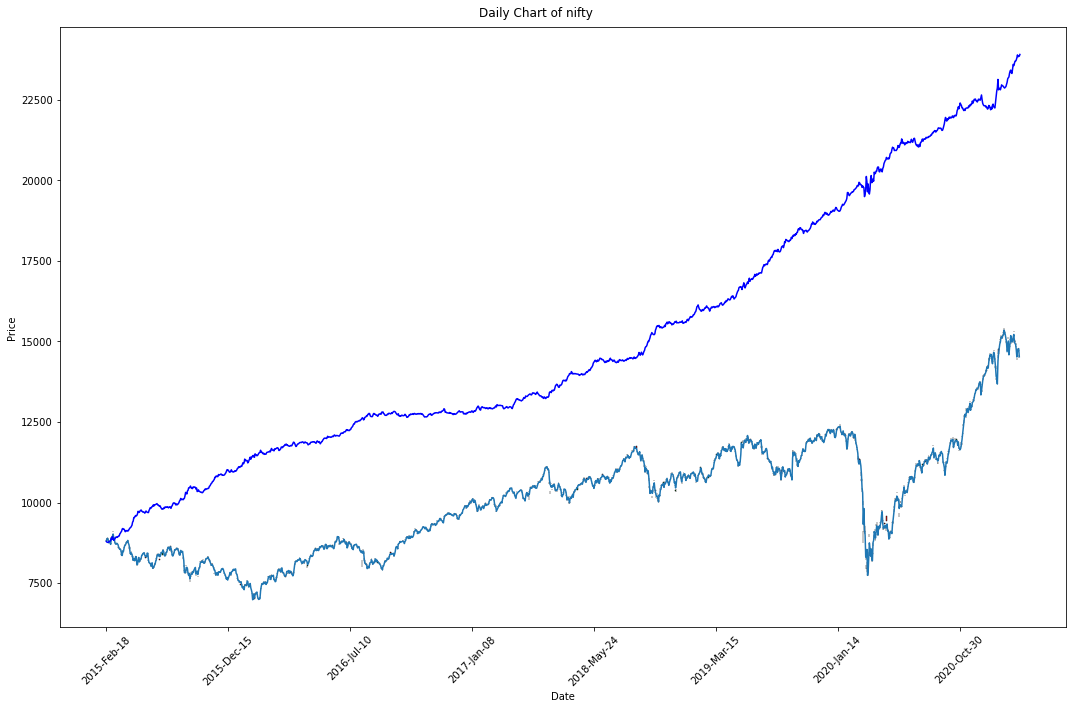

In [13]:
f=75
plotnifty=nifty5.iloc[a*75::f, :]
plotnifty.index= pd.to_datetime(plotnifty.Date)
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty=plotnifty.iloc[1:,:]
#Creating Subplots
fig, ax = plt.subplots(figsize=(15,10))
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values)
plt.plot(c2['Balance'][a*75::f].values,'b')

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Daily Chart of nifty')
fig.tight_layout()

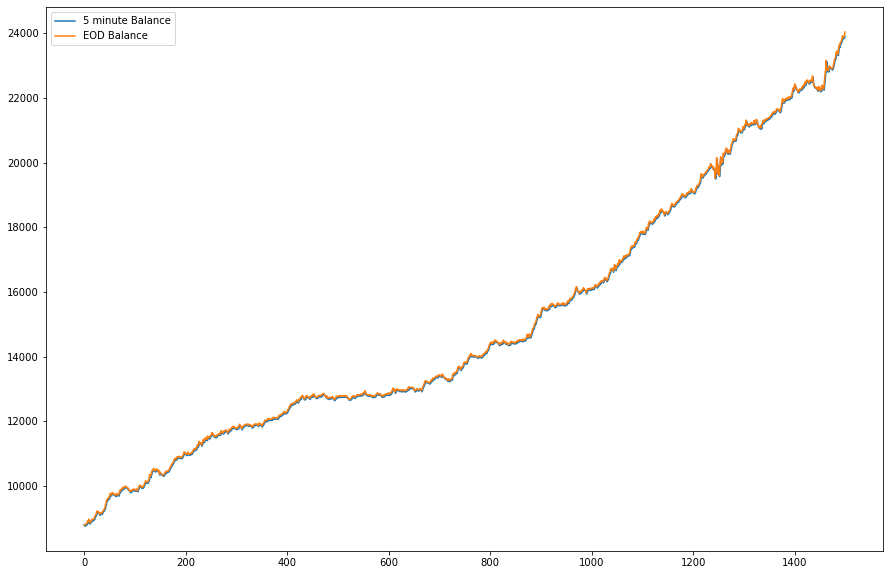

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
plotc1 = c1.drop_duplicates('Date')
plotc1=plotc1[a:]
plotc2=c2['Balance'][a*75::75].values
plotc1['Balance'] = plotc1['Balance']
plotc2=np.array(plotc2)
plt.plot(plotc2,label='5 minute Balance')
plt.plot(plotc1['Balance'].values,label='EOD Balance')

plt.legend()

-46.994166666771875


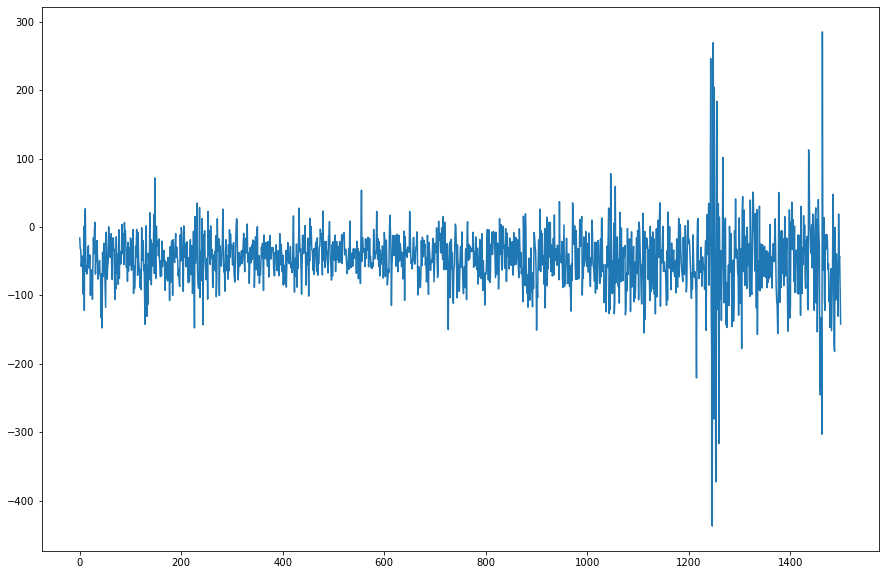

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
x=np.array(plotc2-plotc1['Balance'].values)
plt.plot(x)
print(x.mean())